### Packages

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import scipy.stats as stats
import matplotlib.pyplot as plt

### Cournot

Dynamic Demand:
- $p_t = u_t - v \sum_i q_{it} + x_t$ 
- $x_t = \rho x_{t-1} + e_t, e_t \sim N(0,\sigma)$

Walrasian 
- $\pi_w = \max_{q_i}{(p - w) q_i}$ 
- $w = u - v Q$
- $Q_w = \frac{u-w}{v}$
- $P_w = w$
- $q_w \in [0,Q_w], \pi_w = 0, \Pi_w = 0$

Nash
- $\pi_c = \max_{q_i}{(p(Q) - w) q_i}$ 
- $p(Q) - w - v q_i = 0$
- $n p(Q) = n w + v Q = n u - n v Q$
- $Q_c = \frac{n(u-w)}{v(n+1)}$
- $P_c = u - v Q$
- $q_c = Q_c/n$

Monopoly
- $\pi_m = \max_{Q}{(p(Q) - w) Q}$ 
- $p(Q)=w+vQ=u-vQ$ 
- $Q_m =\frac{u-w}{2v}$ 
- $P_m =\frac{u-w}{2v}$


In [96]:
# parameters of model
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.2
rho = 0.95

In [97]:
def price(Q,u,v):
    return u-v*Q

def profit(P,Q):
    return
           
class cournot:
    def __init__(self,u,v,w,n):
        self.u=u
        self.v=v
        self.w=w
        self.n=n
        self.Qw=(u-w)/v
        self.Qc=n*(u-w)/v/(n+1)
        self.Qm=(u-w)/2*v
        self.Pw = price(self.Qw,u,v)
        self.Pc = price(self.Qc,u,v)
        self.Pm = price(self.Qm,u,v)
        self.Πw = 0
        self.Πc = (self.Pc-w)*self.Qc
        self.Πm = (self.Pm-w)*self.Qm
        self.qw = self.Qw/n
        self.qc = self.Qc/n
        self.qm = self.Qm/n
        self.πw = 0
        self.πc = self.Πc/n
        self.πm = self.Πm/n
    
    def price(self,Q):
        return self.u-v*(Q)
    
    def profit(self,Q):
        return (self.price(Q)-w)*Q
        
game1 = cournot(40,1,4,2)

In [98]:
game1.Qc, game1.qc, game1.Pc, game1.w, game1.Πc, game1.Πm, game1.profit(game1.Qm)

(24.0, 12.0, 16.0, 4, 288.0, 324.0, 324.0)

In [99]:
game1.Qm, game1.qm, game1.Pm, game1.w, game1.Πm, game1.profit(9)

(18.0, 9.0, 22.0, 4, 324.0, 243)

### Shocks

In [100]:
# Input: ρ, σ, K
# Output: KxK Transition Matrix
ρ, σ, K = 0.9, 1, 10
σy = σ/np.sqrt(1-ρ**2)

def tauchen(ρ, σ, K, m=3):
    Z = np.linspace(-m * σ/np.sqrt(1-ρ**2), m * σ/np.sqrt(1-ρ**2), K) # Shock Space
    F = lambda x: stats.norm.cdf(x, 0, σ) # CDF Function for Standard Normal
    α = Z[2] - Z[1] # Step Size
    P = np.zeros((K,K)) # Placeholder Transition Matrix
    # P[i,j] is probability of process going from Zi to Zj 
    for i in range(K):
        for j in range(K):
            if j == 1:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i])
            elif j == K:
                P[i, j] = 1 - F(Z[j]-α/2-ρ*Z[i])
            else:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i]) - F(Z[j]-α/2-ρ*Z[i])
        P[i, :] = P[i, :]/sum(P[i, :])
    return Z, α, F, P
        
def whichidx(value, array):
    return np.argmin(np.abs(array-value))

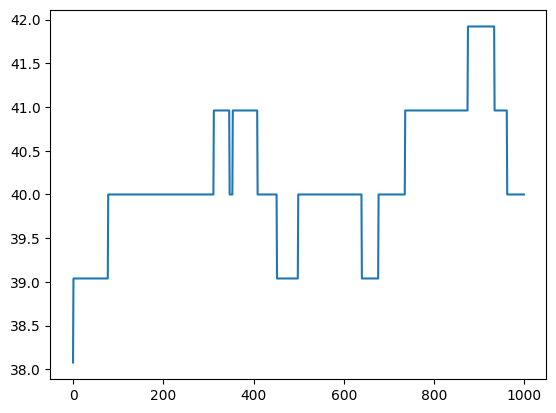

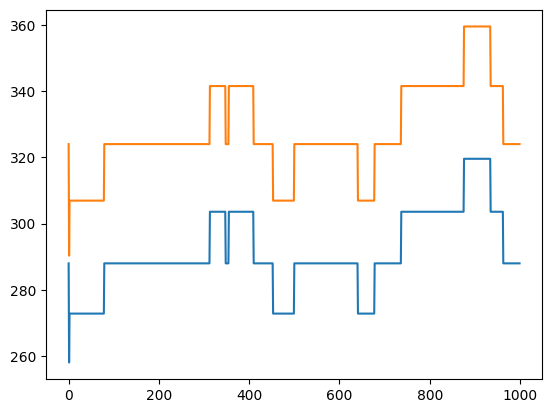

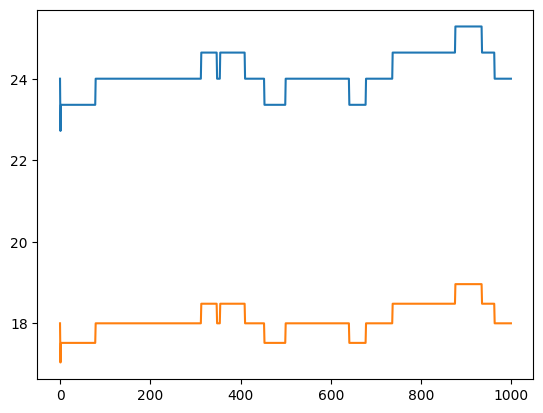

In [101]:
import numpy as np
e = np.random.normal(1)*sigma
K = 5
Z, α, F, P = tauchen(rho, sigma, K, m=3)
u_history=[]
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

uidx = 0
for t in range(1000):
    # find competition level profit 
    qc_history.append(cournot(u,v,w,n).Qc)
    qm_history.append(cournot(u,v,w,n).Qm)
    pc_history.append(cournot(u,v,w,n).Πc)
    pm_history.append(cournot(u,v,w,n).Πm)
   
    # generate next shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    u_history.append(u)
    
plt.plot(u_history)
plt.show()

plt.plot(pc_history)
plt.plot(pm_history)
plt.show()

plt.plot(qc_history)
plt.plot(qm_history)
plt.show()

### Q-Learning

In [140]:
import random
import numpy as np

# define the Boltzmann action selection function
def boltzmann_action_selection(Q, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state2,:])
    logits = (Q[state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    action = np.random.choice(range(len(probs)), p=probs)
    return action

# initialize the state
state1 = 0
state2 = 0
u = 0
uidx = 0

# initialize the Q-table
game = game1
num_states1 = 25
num_states2 = 5
num_actions = 25
Z, α, F, P = tauchen(rho, sigma, num_states2, m=3)
uidx = int(round(num_states2/2))

# parameters of model
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.05
rho = 0.97

Q1 = np.random.uniform(cournot(u,v,w,n).Πc,cournot(u,v,w,n).Πm,(num_states2, num_actions))

# histories
q1_history = []
u_history = []
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

action2quantity = np.linspace(17,19,num_actions)
action2quantity

array([17.  , 17.08, 17.17, 17.25, 17.33, 17.42, 17.5 , 17.58, 17.67,
       17.75, 17.83, 17.92, 18.  , 18.08, 18.17, 18.25, 18.33, 18.42,
       18.5 , 18.58, 18.67, 18.75, 18.83, 18.92, 19.  ])

In [162]:
# initialize Boltzmann Q-learning parameters
alpha = 0.1
initial_temperature = 1.0
temperature_decay = 0.9999
min_temperature = 0.001
temperature = initial_temperature
initial_eps = 1.0
eps_decay = 0.9999
min_eps = 0.01
eps = initial_eps
errors = []

In [172]:
temperature=0.0001
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 100000
for episode in range(num_episodes):

    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action1 = boltzmann_action_selection(Q1, uidx, temperature)
    else:
        action1 = np.random.choice(range(num_actions))

    quantity1 = action2quantity[action1]

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1)

    # update the Q-value for the selected action in the current state
    Q1[uidx][action1] =  (1-alpha)*Q1[uidx][action1] + alpha * (reward1 + gamma * np.max(np.average(Q1,axis=0,weights=P[uidx])))
    
    # generate shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    
    # update temperature
    temperature = max(min_temperature, temperature * temperature_decay)
    eps = max(min_eps, eps * eps_decay)
    error = reward1 + gamma * np.max(Q1[uidx])-Q1[uidx][action1] 
    errors.append(error)
    if num_episodes>1000:
        print(f'{episode},{np.mean(errors[-1000:]):0.2f},{uidx:0.2f}, {action1:0.2f}, {reward1:0.2f},  {temperature:0.2f}, {eps:0.2f}')
    
    u_history.append(u)
    q1_history.append(quantity1)
    qc_history.append(cournot(u,v,w,n).Qc)
    qm_history.append(cournot(u,v,w,n).Qm)
    pc_history.append(cournot(u,v,w,n).profit(quantity1))
  

0,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
1,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
2,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
3,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
4,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
5,-0.04,2.00, 22.00, 323.31,  0.00, 0.01
6,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
7,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
8,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
9,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
10,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
11,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
12,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
13,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
14,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
15,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
16,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
17,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
18,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
19,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
21,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
22,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
23,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
24

651,0.05,2.00, 12.00, 324.00,  0.00, 0.01
652,0.05,2.00, 12.00, 324.00,  0.00, 0.01
653,0.05,2.00, 12.00, 324.00,  0.00, 0.01
654,0.05,2.00, 12.00, 324.00,  0.00, 0.01
655,0.05,2.00, 12.00, 324.00,  0.00, 0.01
656,0.05,2.00, 12.00, 324.00,  0.00, 0.01
657,0.05,2.00, 12.00, 324.00,  0.00, 0.01
658,0.05,2.00, 12.00, 324.00,  0.00, 0.01
659,0.05,2.00, 12.00, 324.00,  0.00, 0.01
660,0.05,2.00, 12.00, 324.00,  0.00, 0.01
661,0.05,2.00, 12.00, 324.00,  0.00, 0.01
662,0.05,2.00, 12.00, 324.00,  0.00, 0.01
663,0.05,2.00, 12.00, 324.00,  0.00, 0.01
664,0.05,2.00, 12.00, 324.00,  0.00, 0.01
665,0.05,2.00, 12.00, 324.00,  0.00, 0.01
666,0.05,2.00, 12.00, 324.00,  0.00, 0.01
667,0.05,2.00, 12.00, 324.00,  0.00, 0.01
668,0.05,2.00, 12.00, 324.00,  0.00, 0.01
669,0.05,2.00, 12.00, 324.00,  0.00, 0.01
670,0.05,2.00, 12.00, 324.00,  0.00, 0.01
671,0.05,2.00, 12.00, 324.00,  0.00, 0.01
672,0.05,2.00, 12.00, 324.00,  0.00, 0.01
673,0.05,2.00, 12.00, 324.00,  0.00, 0.01
674,0.05,2.00, 12.00, 324.00,  0.0

1151,0.06,3.00, 4.00, 328.90,  0.00, 0.01
1152,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1153,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1154,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1155,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1156,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1157,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1158,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1159,0.06,3.00, 13.00, 329.57,  0.00, 0.01
1160,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1161,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1162,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1163,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1164,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1165,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1166,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1167,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1168,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1169,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1170,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1171,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1172,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1173,0.06,3.00, 14.00, 329.58,  0.00, 0.01
1174,0.06,3.

1643,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1644,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1645,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1646,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1647,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1648,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1649,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1650,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1651,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1652,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1653,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1654,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1655,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1656,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1657,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1658,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1659,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1660,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1661,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1662,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1663,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1664,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1665,0.12,3.00, 14.00, 329.58,  0.00, 0.01
1666,0.12,3

2078,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2079,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2080,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2081,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2082,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2083,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2084,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2085,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2086,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2087,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2088,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2089,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2090,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2091,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2092,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2093,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2094,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2095,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2096,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2097,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2098,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2099,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2100,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2101,0.22,3

2547,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2548,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2549,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2550,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2551,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2552,0.22,3.00, 14.00, 329.58,  0.00, 0.01
2553,0.22,2.00, 14.00, 329.58,  0.00, 0.01
2554,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2555,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2556,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2557,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2558,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2559,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2560,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2561,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2562,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2563,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2564,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2565,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2566,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2567,0.22,2.00, 7.00, 323.83,  0.00, 0.01
2568,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2569,0.22,2.00, 12.00, 324.00,  0.00, 0.01
2570,0.22,2.

3078,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3079,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3080,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3081,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3082,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3083,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3084,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3085,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3086,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3087,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3088,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3089,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3090,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3091,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3092,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3093,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3094,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3095,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3096,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3097,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3098,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3099,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3100,0.14,1.00, 10.00, 318.47,  0.00, 0.01
3101,0.14,1

3592,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3593,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3594,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3595,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3596,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3597,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3598,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3599,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3600,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3601,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3602,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3603,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3604,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3605,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3606,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3607,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3608,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3609,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3610,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3611,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3612,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3613,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3614,0.02,2.00, 12.00, 324.00,  0.00, 0.01
3615,0.02,2

3936,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3937,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3938,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3939,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3940,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3941,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3942,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3943,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3944,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3945,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3946,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3947,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3948,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3949,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3950,-0.03,1.00, 0.00, 317.76,  0.00, 0.01
3951,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3952,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3953,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3954,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3955,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3956,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3957,-0.03,1.00, 10.00, 318.47,  0.00, 0.01
3958,-0.03,1.00, 10.00, 318.47,  

4257,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4258,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4259,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4260,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4261,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4262,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4263,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4264,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4265,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4266,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4267,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4268,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4269,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4270,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4271,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4272,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4273,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4274,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4275,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4276,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4277,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4278,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4279,2.80,1.00, 10.00, 318.47,  0.00, 0.01
4280,2.80,1

4683,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4684,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4685,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4686,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4687,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4688,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4689,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4690,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4691,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4692,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4693,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4694,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4695,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4696,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4697,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4698,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4699,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4700,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4701,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4702,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4703,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4704,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4705,2.83,2.00, 12.00, 324.00,  0.00, 0.01
4706,2.83,2

5191,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5192,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5193,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5194,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5195,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5196,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5197,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5198,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5199,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5200,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5201,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5202,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5203,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5204,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5205,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5206,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5207,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5208,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5209,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5210,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5211,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5212,0.90,4.00, 7.00, 334.68,  0.00, 0.01
5213,1.37,4.00, 17.00, 335.19,  0.00, 0.01
5214,1.37,4.00, 7.00, 334.68,  0.

5573,2.47,4.00, 7.00, 334.68,  0.00, 0.01
5574,2.47,4.00, 7.00, 334.68,  0.00, 0.01
5575,2.47,4.00, 7.00, 334.68,  0.00, 0.01
5576,2.47,4.00, 7.00, 334.68,  0.00, 0.01
5577,2.47,4.00, 7.00, 334.68,  0.00, 0.01
5578,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5579,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5580,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5581,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5582,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5583,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5584,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5585,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5586,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5587,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5588,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5589,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5590,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5591,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5592,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5593,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5594,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5595,2.48,4.00, 7.00, 334.68,  0.00, 0.01
5596,2.48,4.00, 7.00, 334.68,  0.0

5810,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5811,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5812,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5813,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5814,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5815,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5816,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5817,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5818,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5819,3.10,4.00, 7.00, 334.68,  0.00, 0.01
5820,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5821,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5822,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5823,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5824,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5825,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5826,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5827,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5828,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5829,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5830,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5831,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5832,3.11,4.00, 7.00, 334.68,  0.00, 0.01
5833,3.11,4.00, 7.00, 334.68,  0.0

6360,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6361,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6362,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6363,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6364,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6365,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6366,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6367,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6368,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6369,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6370,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6371,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6372,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6373,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6374,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6375,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6376,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6377,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6378,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6379,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6380,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6381,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6382,2.86,4.00, 7.00, 334.68,  0.00, 0.01
6383,2.86,4.00, 7.00, 334.68,  0.0

6795,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6796,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6797,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6798,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6799,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6800,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6801,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6802,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6803,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6804,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6805,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6806,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6807,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6808,2.23,3.00, 14.00, 329.58,  0.00, 0.01
6809,2.24,2.00, 14.00, 329.58,  0.00, 0.01
6810,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6811,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6812,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6813,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6814,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6815,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6816,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6817,2.24,2.00, 12.00, 324.00,  0.00, 0.01
6818,2.24,2

7034,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7035,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7036,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7037,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7038,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7039,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7040,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7041,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7042,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7043,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7044,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7045,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7046,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7047,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7048,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7049,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7050,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7051,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7052,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7053,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7054,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7055,1.66,2.00, 12.00, 324.00,  0.00, 0.01
7056,1.65,2.00, 12.00, 324.00,  0.00, 0.01
7057,1.65,2

7275,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7276,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7277,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7278,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7279,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7280,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7281,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7282,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7283,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7284,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7285,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7286,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7287,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7288,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7289,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7290,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7291,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7292,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7293,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7294,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7295,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7296,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7297,0.36,2.00, 12.00, 324.00,  0.00, 0.01
7298,0.36,2

7676,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7677,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7678,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7679,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7680,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7681,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7682,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7683,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7684,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7685,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7686,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7687,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7688,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7689,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7690,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7691,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7692,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7693,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7694,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7695,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7696,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7697,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7698,0.10,3.00, 14.00, 329.58,  0.00, 0.01
7699,0.10,3

7879,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7880,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7881,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7882,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7883,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7884,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7885,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7886,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7887,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7888,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7889,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7890,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7891,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7892,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7893,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7894,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7895,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7896,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7897,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7898,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7899,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7900,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7901,0.11,3.00, 14.00, 329.58,  0.00, 0.01
7902,0.11,3

8302,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8303,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8304,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8305,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8306,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8307,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8308,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8309,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8310,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8311,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8312,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8313,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8314,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8315,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8316,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8317,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8318,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8319,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8320,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8321,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8322,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8323,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8324,0.17,3.00, 14.00, 329.58,  0.00, 0.01
8325,0.17,3

8496,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8497,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8498,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8499,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8500,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8501,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8502,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8503,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8504,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8505,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8506,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8507,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8508,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8509,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8510,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8511,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8512,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8513,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8514,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8515,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8516,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8517,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8518,0.21,3.00, 14.00, 329.58,  0.00, 0.01
8519,0.20,3

8808,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8809,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8810,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8811,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8812,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8813,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8814,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8815,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8816,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8817,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8818,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8819,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8820,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8821,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8822,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8823,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8824,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8825,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8826,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8827,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8828,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8829,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8830,0.20,3.00, 14.00, 329.58,  0.00, 0.01
8831,0.20,3

9051,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9052,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9053,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9054,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9055,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9056,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9057,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9058,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9059,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9060,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9061,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9062,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9063,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9064,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9065,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9066,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9067,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9068,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9069,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9070,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9071,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9072,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9073,0.18,2.00, 12.00, 324.00,  0.00, 0.01
9074,0.18,2

9428,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9429,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9430,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9431,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9432,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9433,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9434,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9435,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9436,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9437,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9438,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9439,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9440,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9441,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9442,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9443,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9444,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9445,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9446,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9447,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9448,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9449,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9450,0.10,2.00, 12.00, 324.00,  0.00, 0.01
9451,0.10,2

9947,0.00,1.00, 10.00, 318.47,  0.00, 0.01
9948,2.86,0.00, 10.00, 318.47,  0.00, 0.01
9949,2.85,0.00, 11.00, 312.94,  0.00, 0.01
9950,2.85,0.00, 11.00, 312.94,  0.00, 0.01
9951,2.84,0.00, 11.00, 312.94,  0.00, 0.01
9952,2.84,0.00, 11.00, 312.94,  0.00, 0.01
9953,2.84,0.00, 11.00, 312.94,  0.00, 0.01
9954,2.83,1.00, 11.00, 312.94,  0.00, 0.01
9955,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9956,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9957,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9958,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9959,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9960,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9961,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9962,2.83,1.00, 5.00, 318.29,  0.00, 0.01
9963,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9964,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9965,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9966,2.83,1.00, 11.00, 318.47,  0.00, 0.01
9967,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9968,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9969,2.83,1.00, 10.00, 318.47,  0.00, 0.01
9970,2.83,1.

10143,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10144,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10145,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10146,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10147,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10148,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10149,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10150,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10151,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10152,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10153,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10154,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10155,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10156,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10157,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10158,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10159,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10160,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10161,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10162,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10163,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10164,2.81,1.00, 10.00, 318.47,  0.00, 0.01
10165,2.81,1.00, 10.00, 318.47, 

10428,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10429,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10430,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10431,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10432,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10433,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10434,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10435,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10436,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10437,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10438,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10439,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10440,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10441,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10442,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10443,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10444,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10445,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10446,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10447,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10448,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10449,2.80,3.00, 14.00, 329.58,  0.00, 0.01
10450,2.80,3.00, 14.00, 329.58, 

10644,2.84,3.00, 14.00, 329.58,  0.00, 0.01
10645,2.84,3.00, 14.00, 329.58,  0.00, 0.01
10646,2.84,3.00, 14.00, 329.58,  0.00, 0.01
10647,2.84,3.00, 14.00, 329.58,  0.00, 0.01
10648,2.84,3.00, 14.00, 329.58,  0.00, 0.01
10649,2.84,3.00, 14.00, 329.58,  0.00, 0.01
10650,2.84,3.00, 14.00, 329.58,  0.00, 0.01
10651,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10652,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10653,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10654,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10655,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10656,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10657,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10658,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10659,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10660,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10661,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10662,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10663,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10664,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10665,2.85,3.00, 14.00, 329.58,  0.00, 0.01
10666,2.85,3.00, 14.00, 329.58, 

10854,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10855,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10856,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10857,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10858,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10859,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10860,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10861,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10862,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10863,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10864,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10865,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10866,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10867,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10868,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10869,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10870,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10871,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10872,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10873,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10874,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10875,2.89,3.00, 14.00, 329.58,  0.00, 0.01
10876,2.89,3.00, 14.00, 329.58, 

11235,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11236,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11237,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11238,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11239,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11240,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11241,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11242,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11243,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11244,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11245,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11246,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11247,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11248,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11249,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11250,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11251,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11252,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11253,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11254,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11255,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11256,1.75,3.00, 14.00, 329.58,  0.00, 0.01
11257,1.75,3.00, 14.00, 329.58, 

11486,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11487,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11488,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11489,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11490,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11491,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11492,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11493,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11494,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11495,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11496,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11497,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11498,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11499,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11500,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11501,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11502,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11503,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11504,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11505,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11506,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11507,1.79,3.00, 14.00, 329.58,  0.00, 0.01
11508,1.79,3.00, 14.00, 329.58, 

11683,1.78,2.00, 12.00, 324.00,  0.00, 0.01
11684,1.78,2.00, 12.00, 324.00,  0.00, 0.01
11685,1.78,2.00, 12.00, 324.00,  0.00, 0.01
11686,1.78,2.00, 12.00, 324.00,  0.00, 0.01
11687,1.78,2.00, 12.00, 324.00,  0.00, 0.01
11688,1.78,2.00, 12.00, 324.00,  0.00, 0.01
11689,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11690,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11691,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11692,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11693,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11694,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11695,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11696,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11697,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11698,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11699,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11700,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11701,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11702,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11703,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11704,1.77,2.00, 12.00, 324.00,  0.00, 0.01
11705,1.77,2.00, 12.00, 324.00, 

12062,0.93,2.00, 12.00, 324.00,  0.00, 0.01
12063,0.93,2.00, 12.00, 324.00,  0.00, 0.01
12064,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12065,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12066,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12067,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12068,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12069,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12070,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12071,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12072,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12073,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12074,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12075,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12076,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12077,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12078,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12079,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12080,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12081,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12082,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12083,0.53,2.00, 12.00, 324.00,  0.00, 0.01
12084,0.53,2.00, 12.00, 324.00, 

12471,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12472,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12473,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12474,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12475,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12476,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12477,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12478,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12479,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12480,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12481,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12482,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12483,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12484,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12485,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12486,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12487,0.03,2.00, 12.00, 324.00,  0.00, 0.01
12488,0.02,2.00, 12.00, 324.00,  0.00, 0.01
12489,0.02,2.00, 12.00, 324.00,  0.00, 0.01
12490,0.02,2.00, 12.00, 324.00,  0.00, 0.01
12491,0.02,2.00, 12.00, 324.00,  0.00, 0.01
12492,0.02,2.00, 12.00, 324.00,  0.00, 0.01
12493,0.02,2.00, 12.00, 324.00, 

12658,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12659,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12660,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12661,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12662,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12663,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12664,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12665,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12666,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12667,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12668,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12669,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12670,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12671,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12672,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12673,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12674,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12675,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12676,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12677,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12678,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12679,0.00,2.00, 12.00, 324.00,  0.00, 0.01
12680,0.00,2.00, 12.00, 324.00, 

12856,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12857,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12858,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12859,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12860,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12861,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12862,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12863,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12864,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12865,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12866,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12867,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12868,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12869,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12870,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12871,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12872,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12873,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12874,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12875,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12876,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12877,0.03,3.00, 14.00, 329.58,  0.00, 0.01
12878,0.03,3.00, 14.00, 329.58, 

13229,0.10,3.00, 14.00, 329.58,  0.00, 0.01
13230,0.10,3.00, 14.00, 329.58,  0.00, 0.01
13231,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13232,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13233,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13234,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13235,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13236,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13237,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13238,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13239,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13240,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13241,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13242,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13243,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13244,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13245,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13246,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13247,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13248,0.11,3.00, 23.00, 329.00,  0.00, 0.01
13249,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13250,0.11,3.00, 14.00, 329.58,  0.00, 0.01
13251,0.11,3.00, 14.00, 329.58, 

13486,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13487,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13488,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13489,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13490,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13491,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13492,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13493,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13494,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13495,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13496,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13497,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13498,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13499,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13500,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13501,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13502,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13503,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13504,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13505,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13506,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13507,0.14,2.00, 12.00, 324.00,  0.00, 0.01
13508,0.14,2.00, 12.00, 324.00, 

13738,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13739,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13740,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13741,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13742,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13743,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13744,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13745,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13746,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13747,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13748,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13749,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13750,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13751,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13752,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13753,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13754,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13755,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13756,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13757,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13758,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13759,0.13,2.00, 12.00, 324.00,  0.00, 0.01
13760,0.13,2.00, 12.00, 324.00, 

14223,0.02,2.00, 12.00, 324.00,  0.00, 0.01
14224,0.02,2.00, 12.00, 324.00,  0.00, 0.01
14225,0.02,2.00, 12.00, 324.00,  0.00, 0.01
14226,0.02,2.00, 12.00, 324.00,  0.00, 0.01
14227,0.02,2.00, 12.00, 324.00,  0.00, 0.01
14228,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14229,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14230,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14231,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14232,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14233,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14234,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14235,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14236,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14237,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14238,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14239,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14240,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14241,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14242,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14243,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14244,0.01,2.00, 12.00, 324.00,  0.00, 0.01
14245,0.01,2.00, 12.00, 324.00, 

14600,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14601,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14602,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14603,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14604,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14605,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14606,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14607,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14608,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14609,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14610,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14611,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14612,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14613,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14614,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14615,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14616,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14617,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14618,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14619,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14620,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14621,0.01,3.00, 14.00, 329.58,  0.00, 0.01
14622,0.01,3.00, 14.00, 329.58, 

14837,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14838,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14839,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14840,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14841,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14842,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14843,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14844,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14845,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14846,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14847,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14848,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14849,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14850,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14851,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14852,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14853,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14854,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14855,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14856,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14857,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14858,0.06,3.00, 14.00, 329.58,  0.00, 0.01
14859,0.06,3.00, 14.00, 329.58, 

15209,0.14,3.00, 14.00, 329.58,  0.00, 0.01
15210,0.14,3.00, 14.00, 329.58,  0.00, 0.01
15211,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15212,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15213,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15214,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15215,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15216,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15217,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15218,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15219,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15220,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15221,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15222,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15223,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15224,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15225,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15226,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15227,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15228,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15229,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15230,0.15,3.00, 14.00, 329.58,  0.00, 0.01
15231,0.15,3.00, 14.00, 329.58, 

15547,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15548,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15549,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15550,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15551,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15552,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15553,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15554,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15555,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15556,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15557,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15558,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15559,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15560,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15561,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15562,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15563,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15564,0.20,3.00, 14.00, 329.58,  0.00, 0.01
15565,0.21,2.00, 14.00, 329.58,  0.00, 0.01
15566,0.21,2.00, 12.00, 324.00,  0.00, 0.01
15567,0.21,2.00, 12.00, 324.00,  0.00, 0.01
15568,0.21,2.00, 12.00, 324.00,  0.00, 0.01
15569,0.21,2.00, 12.00, 324.00, 

15788,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15789,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15790,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15791,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15792,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15793,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15794,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15795,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15796,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15797,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15798,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15799,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15800,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15801,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15802,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15803,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15804,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15805,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15806,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15807,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15808,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15809,0.16,2.00, 12.00, 324.00,  0.00, 0.01
15810,0.16,2.00, 12.00, 324.00, 

15975,0.13,2.00, 12.00, 324.00,  0.00, 0.01
15976,0.13,2.00, 12.00, 324.00,  0.00, 0.01
15977,0.13,2.00, 12.00, 324.00,  0.00, 0.01
15978,0.13,2.00, 12.00, 324.00,  0.00, 0.01
15979,0.13,2.00, 12.00, 324.00,  0.00, 0.01
15980,0.13,2.00, 12.00, 324.00,  0.00, 0.01
15981,0.13,2.00, 12.00, 324.00,  0.00, 0.01
15982,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15983,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15984,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15985,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15986,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15987,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15988,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15989,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15990,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15991,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15992,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15993,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15994,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15995,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15996,0.12,2.00, 12.00, 324.00,  0.00, 0.01
15997,0.12,2.00, 12.00, 324.00, 

16232,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16233,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16234,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16235,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16236,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16237,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16238,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16239,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16240,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16241,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16242,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16243,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16244,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16245,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16246,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16247,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16248,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16249,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16250,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16251,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16252,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16253,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16254,0.07,2.00, 12.00, 324.00, 

16460,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16461,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16462,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16463,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16464,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16465,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16466,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16467,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16468,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16469,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16470,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16471,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16472,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16473,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16474,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16475,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16476,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16477,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16478,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16479,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16480,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16481,0.05,3.00, 14.00, 329.58,  0.00, 0.01
16482,0.05,3.00, 14.00, 329.58, 

16739,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16740,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16741,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16742,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16743,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16744,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16745,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16746,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16747,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16748,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16749,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16750,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16751,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16752,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16753,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16754,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16755,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16756,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16757,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16758,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16759,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16760,0.07,2.00, 12.00, 324.00,  0.00, 0.01
16761,0.07,2.00, 12.00, 324.00, 

17137,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17138,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17139,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17140,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17141,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17142,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17143,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17144,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17145,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17146,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17147,0.07,3.00, 14.00, 329.58,  0.00, 0.01
17148,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17149,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17150,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17151,0.08,3.00, 16.00, 329.54,  0.00, 0.01
17152,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17153,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17154,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17155,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17156,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17157,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17158,0.08,3.00, 14.00, 329.58,  0.00, 0.01
17159,0.08,3.00, 14.00, 329.58, 

17397,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17398,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17399,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17400,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17401,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17402,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17403,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17404,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17405,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17406,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17407,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17408,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17409,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17410,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17411,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17412,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17413,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17414,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17415,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17416,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17417,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17418,0.10,2.00, 12.00, 324.00,  0.00, 0.01
17419,0.10,2.00, 12.00, 324.00, 

17866,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17867,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17868,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17869,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17870,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17871,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17872,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17873,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17874,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17875,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17876,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17877,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17878,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17879,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17880,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17881,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17882,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17883,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17884,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17885,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17886,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17887,0.04,1.00, 10.00, 318.47,  0.00, 0.01
17888,0.04,1.00, 10.00, 318.47, 

18486,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18487,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18488,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18489,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18490,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18491,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18492,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18493,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18494,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18495,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18496,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18497,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18498,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18499,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18500,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18501,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18502,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18503,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18504,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18505,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18506,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18507,-0.06,1.00, 10.00, 318.47,  0.00, 0.01
18508,-0.0

18963,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18964,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18965,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18966,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18967,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18968,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18969,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18970,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18971,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18972,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18973,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18974,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18975,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18976,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18977,2.77,1.00, 10.00, 318.47,  0.00, 0.01
18978,2.76,2.00, 10.00, 318.47,  0.00, 0.01
18979,2.76,2.00, 12.00, 324.00,  0.00, 0.01
18980,2.76,2.00, 12.00, 324.00,  0.00, 0.01
18981,2.76,2.00, 12.00, 324.00,  0.00, 0.01
18982,2.76,2.00, 12.00, 324.00,  0.00, 0.01
18983,2.76,2.00, 12.00, 324.00,  0.00, 0.01
18984,2.76,2.00, 12.00, 324.00,  0.00, 0.01
18985,2.76,2.00, 12.00, 324.00, 

19196,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19197,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19198,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19199,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19200,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19201,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19202,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19203,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19204,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19205,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19206,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19207,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19208,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19209,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19210,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19211,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19212,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19213,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19214,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19215,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19216,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19217,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19218,2.78,1.00, 10.00, 318.47, 

19459,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19460,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19461,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19462,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19463,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19464,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19465,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19466,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19467,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19468,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19469,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19470,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19471,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19472,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19473,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19474,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19475,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19476,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19477,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19478,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19479,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19480,2.78,1.00, 10.00, 318.47,  0.00, 0.01
19481,2.78,1.00, 10.00, 318.47, 

19714,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19715,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19716,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19717,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19718,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19719,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19720,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19721,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19722,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19723,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19724,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19725,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19726,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19727,2.78,2.00, 12.00, 324.00,  0.00, 0.01
19728,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19729,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19730,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19731,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19732,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19733,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19734,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19735,-0.07,2.00, 12.00, 324.00,  0.00, 0.01
19736,-0.07,2.00, 12.00,

19923,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19924,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19925,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19926,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19927,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19928,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19929,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19930,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19931,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19932,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19933,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19934,-0.05,2.00, 24.00, 323.00,  0.00, 0.01
19935,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19936,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19937,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19938,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19939,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19940,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19941,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19942,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19943,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19944,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
19945,-0.0

20128,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20129,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20130,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20131,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20132,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20133,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20134,-0.04,2.00, 12.00, 324.00,  0.00, 0.01
20135,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20136,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20137,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20138,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20139,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20140,-0.05,2.00, 6.00, 323.75,  0.00, 0.01
20141,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20142,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20143,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20144,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20145,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20146,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20147,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20148,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20149,-0.05,2.00, 12.00, 324.00,  0.00, 0.01
20150,-0.05

20410,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20411,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20412,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20413,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20414,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20415,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20416,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20417,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20418,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20419,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20420,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20421,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20422,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20423,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20424,0.00,3.00, 14.00, 329.58,  0.00, 0.01
20425,0.01,3.00, 14.00, 329.58,  0.00, 0.01
20426,0.01,3.00, 14.00, 329.58,  0.00, 0.01
20427,0.01,3.00, 14.00, 329.58,  0.00, 0.01
20428,0.01,3.00, 14.00, 329.58,  0.00, 0.01
20429,0.01,3.00, 14.00, 329.58,  0.00, 0.01
20430,0.01,3.00, 14.00, 329.58,  0.00, 0.01
20431,0.01,3.00, 14.00, 329.58,  0.00, 0.01
20432,0.01,3.00, 14.00, 329.58, 

20646,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20647,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20648,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20649,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20650,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20651,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20652,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20653,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20654,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20655,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20656,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20657,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20658,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20659,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20660,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20661,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20662,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20663,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20664,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20665,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20666,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20667,0.06,2.00, 12.00, 324.00,  0.00, 0.01
20668,0.06,2.00, 12.00, 324.00, 

20909,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20910,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20911,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20912,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20913,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20914,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20915,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20916,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20917,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20918,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20919,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20920,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20921,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20922,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20923,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20924,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20925,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20926,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20927,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20928,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20929,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20930,0.07,3.00, 14.00, 329.58,  0.00, 0.01
20931,0.07,3.00, 14.00, 329.58, 

21106,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21107,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21108,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21109,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21110,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21111,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21112,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21113,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21114,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21115,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21116,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21117,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21118,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21119,0.11,3.00, 23.00, 329.00,  0.00, 0.01
21120,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21121,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21122,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21123,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21124,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21125,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21126,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21127,0.11,3.00, 14.00, 329.58,  0.00, 0.01
21128,0.11,3.00, 14.00, 329.58, 

21450,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21451,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21452,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21453,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21454,0.11,2.00, 0.00, 323.00,  0.00, 0.01
21455,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21456,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21457,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21458,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21459,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21460,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21461,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21462,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21463,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21464,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21465,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21466,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21467,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21468,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21469,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21470,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21471,0.11,2.00, 12.00, 324.00,  0.00, 0.01
21472,0.11,2.00, 12.00, 324.00,  

21980,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21981,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21982,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21983,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21984,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21985,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21986,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21987,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21988,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21989,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21990,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21991,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21992,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21993,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21994,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21995,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21996,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21997,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21998,1.01,3.00, 14.00, 329.58,  0.00, 0.01
21999,1.01,3.00, 14.00, 329.58,  0.00, 0.01
22000,1.01,3.00, 14.00, 329.58,  0.00, 0.01
22001,1.01,3.00, 14.00, 329.58,  0.00, 0.01
22002,1.01,3.00, 14.00, 329.58, 

22502,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22503,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22504,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22505,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22506,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22507,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22508,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22509,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22510,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22511,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22512,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22513,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22514,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22515,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22516,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22517,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22518,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22519,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22520,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22521,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22522,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22523,1.03,2.00, 12.00, 324.00,  0.00, 0.01
22524,1.03,2.00, 12.00, 324.00, 

23081,0.10,3.00, 14.00, 329.58,  0.00, 0.01
23082,0.10,3.00, 14.00, 329.58,  0.00, 0.01
23083,0.10,3.00, 14.00, 329.58,  0.00, 0.01
23084,0.10,3.00, 14.00, 329.58,  0.00, 0.01
23085,0.10,3.00, 14.00, 329.58,  0.00, 0.01
23086,0.11,2.00, 14.00, 329.58,  0.00, 0.01
23087,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23088,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23089,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23090,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23091,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23092,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23093,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23094,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23095,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23096,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23097,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23098,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23099,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23100,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23101,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23102,0.11,2.00, 12.00, 324.00,  0.00, 0.01
23103,0.11,2.00, 12.00, 324.00, 

23451,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23452,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23453,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23454,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23455,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23456,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23457,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23458,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23459,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23460,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23461,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23462,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23463,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23464,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23465,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23466,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23467,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23468,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23469,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23470,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23471,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23472,0.06,2.00, 12.00, 324.00,  0.00, 0.01
23473,0.06,2.00, 12.00, 324.00, 

23691,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23692,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23693,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23694,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23695,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23696,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23697,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23698,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23699,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23700,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23701,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23702,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23703,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23704,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23705,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23706,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23707,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23708,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23709,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23710,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23711,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23712,0.05,2.00, 12.00, 324.00,  0.00, 0.01
23713,0.05,2.00, 12.00, 324.00, 

23930,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23931,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23932,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23933,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23934,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23935,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23936,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23937,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23938,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23939,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23940,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23941,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23942,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23943,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23944,0.04,2.00, 12.00, 324.00,  0.00, 0.01
23945,0.03,2.00, 12.00, 324.00,  0.00, 0.01
23946,0.03,2.00, 12.00, 324.00,  0.00, 0.01
23947,0.03,2.00, 12.00, 324.00,  0.00, 0.01
23948,0.03,2.00, 12.00, 324.00,  0.00, 0.01
23949,0.03,2.00, 12.00, 324.00,  0.00, 0.01
23950,0.03,2.00, 12.00, 324.00,  0.00, 0.01
23951,0.03,2.00, 8.00, 323.89,  0.00, 0.01
23952,0.03,2.00, 12.00, 324.00,  

24138,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24139,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24140,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24141,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24142,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24143,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24144,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24145,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24146,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24147,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24148,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24149,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24150,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24151,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24152,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24153,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24154,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24155,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24156,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24157,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24158,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24159,0.00,2.00, 12.00, 324.00,  0.00, 0.01
24160,0.00,2.00, 12.00, 324.00, 

24337,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24338,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24339,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24340,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24341,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24342,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24343,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24344,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24345,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24346,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24347,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24348,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24349,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24350,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24351,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24352,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24353,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24354,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24355,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24356,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24357,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24358,0.02,3.00, 14.00, 329.58,  0.00, 0.01
24359,0.02,3.00, 14.00, 329.58, 

24528,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24529,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24530,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24531,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24532,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24533,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24534,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24535,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24536,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24537,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24538,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24539,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24540,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24541,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24542,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24543,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24544,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24545,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24546,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24547,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24548,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24549,0.06,2.00, 12.00, 324.00,  0.00, 0.01
24550,0.06,2.00, 12.00, 324.00, 

24812,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24813,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24814,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24815,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24816,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24817,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24818,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24819,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24820,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24821,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24822,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24823,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24824,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24825,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24826,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24827,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24828,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24829,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24830,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24831,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24832,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24833,0.08,2.00, 12.00, 324.00,  0.00, 0.01
24834,0.08,2.00, 12.00, 324.00, 

25028,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25029,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25030,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25031,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25032,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25033,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25034,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25035,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25036,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25037,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25038,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25039,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25040,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25041,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25042,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25043,0.08,1.00, 11.00, 318.47,  0.00, 0.01
25044,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25045,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25046,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25047,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25048,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25049,0.08,1.00, 10.00, 318.47,  0.00, 0.01
25050,0.08,1.00, 10.00, 318.47, 

25240,0.08,2.00, 12.00, 324.00,  0.00, 0.01
25241,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25242,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25243,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25244,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25245,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25246,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25247,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25248,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25249,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25250,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25251,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25252,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25253,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25254,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25255,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25256,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25257,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25258,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25259,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25260,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25261,0.07,2.00, 12.00, 324.00,  0.00, 0.01
25262,0.07,2.00, 12.00, 324.00, 

25460,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25461,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25462,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25463,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25464,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25465,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25466,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25467,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25468,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25469,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25470,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25471,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25472,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25473,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25474,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25475,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25476,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25477,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25478,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25479,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25480,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25481,0.03,2.00, 12.00, 324.00,  0.00, 0.01
25482,0.03,2.00, 12.00, 324.00, 

25723,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25724,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25725,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25726,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25727,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25728,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25729,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25730,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25731,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25732,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25733,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25734,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25735,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25736,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25737,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25738,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25739,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25740,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25741,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25742,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25743,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25744,0.02,3.00, 14.00, 329.58,  0.00, 0.01
25745,0.02,3.00, 14.00, 329.58, 

26028,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26029,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26030,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26031,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26032,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26033,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26034,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26035,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26036,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26037,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26038,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26039,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26040,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26041,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26042,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26043,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26044,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26045,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26046,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26047,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26048,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26049,0.08,2.00, 12.00, 324.00,  0.00, 0.01
26050,0.08,2.00, 12.00, 324.00, 

26253,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26254,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26255,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26256,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26257,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26258,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26259,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26260,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26261,0.09,2.00, 20.00, 323.56,  0.00, 0.01
26262,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26263,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26264,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26265,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26266,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26267,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26268,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26269,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26270,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26271,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26272,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26273,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26274,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26275,0.09,2.00, 12.00, 324.00, 

26512,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26513,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26514,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26515,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26516,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26517,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26518,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26519,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26520,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26521,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26522,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26523,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26524,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26525,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26526,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26527,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26528,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26529,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26530,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26531,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26532,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26533,0.09,2.00, 12.00, 324.00,  0.00, 0.01
26534,0.09,2.00, 12.00, 324.00, 

26753,0.06,2.00, 12.00, 324.00,  0.00, 0.01
26754,0.06,2.00, 12.00, 324.00,  0.00, 0.01
26755,0.06,2.00, 12.00, 324.00,  0.00, 0.01
26756,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26757,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26758,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26759,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26760,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26761,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26762,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26763,0.05,2.00, 17.00, 323.83,  0.00, 0.01
26764,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26765,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26766,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26767,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26768,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26769,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26770,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26771,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26772,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26773,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26774,0.05,2.00, 12.00, 324.00,  0.00, 0.01
26775,0.05,2.00, 12.00, 324.00, 

27020,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27021,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27022,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27023,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27024,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27025,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27026,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27027,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27028,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27029,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27030,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27031,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27032,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27033,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27034,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27035,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27036,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27037,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27038,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27039,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27040,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27041,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27042,0.01,2.00, 12.00, 324.00, 

27245,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27246,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27247,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27248,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27249,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27250,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27251,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27252,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27253,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27254,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27255,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27256,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27257,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27258,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27259,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27260,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27261,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27262,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27263,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27264,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27265,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27266,0.01,2.00, 12.00, 324.00,  0.00, 0.01
27267,0.01,2.00, 12.00, 324.00, 

27457,0.04,3.00, 14.00, 329.58,  0.00, 0.01
27458,0.04,3.00, 14.00, 329.58,  0.00, 0.01
27459,0.04,3.00, 14.00, 329.58,  0.00, 0.01
27460,0.04,3.00, 14.00, 329.58,  0.00, 0.01
27461,0.05,3.00, 8.00, 329.34,  0.00, 0.01
27462,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27463,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27464,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27465,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27466,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27467,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27468,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27469,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27470,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27471,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27472,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27473,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27474,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27475,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27476,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27477,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27478,0.05,3.00, 14.00, 329.58,  0.00, 0.01
27479,0.05,3.00, 14.00, 329.58,  

27794,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27795,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27796,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27797,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27798,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27799,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27800,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27801,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27802,0.11,3.00, 14.00, 329.58,  0.00, 0.01
27803,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27804,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27805,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27806,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27807,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27808,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27809,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27810,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27811,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27812,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27813,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27814,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27815,0.12,3.00, 14.00, 329.58,  0.00, 0.01
27816,0.12,3.00, 14.00, 329.58, 

28006,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28007,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28008,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28009,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28010,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28011,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28012,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28013,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28014,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28015,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28016,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28017,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28018,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28019,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28020,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28021,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28022,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28023,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28024,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28025,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28026,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28027,0.15,3.00, 14.00, 329.58,  0.00, 0.01
28028,0.15,3.00, 14.00, 329.58, 

28228,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28229,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28230,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28231,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28232,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28233,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28234,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28235,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28236,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28237,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28238,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28239,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28240,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28241,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28242,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28243,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28244,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28245,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28246,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28247,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28248,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28249,0.17,2.00, 12.00, 324.00,  0.00, 0.01
28250,0.17,2.00, 12.00, 324.00, 

28442,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28443,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28444,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28445,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28446,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28447,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28448,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28449,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28450,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28451,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28452,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28453,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28454,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28455,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28456,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28457,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28458,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28459,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28460,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28461,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28462,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28463,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28464,0.14,3.00, 14.00, 329.58, 

28669,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28670,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28671,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28672,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28673,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28674,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28675,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28676,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28677,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28678,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28679,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28680,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28681,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28682,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28683,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28684,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28685,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28686,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28687,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28688,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28689,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28690,0.14,3.00, 14.00, 329.58,  0.00, 0.01
28691,0.14,3.00, 14.00, 329.58, 

28907,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28908,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28909,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28910,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28911,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28912,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28913,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28914,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28915,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28916,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28917,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28918,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28919,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28920,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28921,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28922,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28923,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28924,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28925,0.14,2.00, 4.00, 323.56,  0.00, 0.01
28926,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28927,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28928,0.14,2.00, 12.00, 324.00,  0.00, 0.01
28929,0.14,2.00, 12.00, 324.00,  

29107,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29108,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29109,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29110,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29111,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29112,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29113,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29114,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29115,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29116,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29117,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29118,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29119,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29120,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29121,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29122,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29123,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29124,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29125,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29126,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29127,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29128,0.09,2.00, 12.00, 324.00,  0.00, 0.01
29129,0.09,2.00, 12.00, 324.00, 

29407,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29408,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29409,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29410,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29411,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29412,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29413,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29414,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29415,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29416,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29417,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29418,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29419,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29420,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29421,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29422,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29423,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29424,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29425,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29426,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29427,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29428,0.10,2.00, 12.00, 324.00,  0.00, 0.01
29429,0.10,2.00, 12.00, 324.00, 

29617,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29618,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29619,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29620,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29621,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29622,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29623,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29624,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29625,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29626,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29627,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29628,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29629,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29630,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29631,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29632,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29633,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29634,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29635,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29636,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29637,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29638,0.06,2.00, 12.00, 324.00,  0.00, 0.01
29639,0.06,2.00, 12.00, 324.00, 

29898,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29899,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29900,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29901,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29902,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29903,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29904,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29905,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29906,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29907,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29908,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29909,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29910,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29911,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29912,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29913,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29914,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29915,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29916,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29917,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29918,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29919,0.00,2.00, 12.00, 324.00,  0.00, 0.01
29920,0.00,2.00, 12.00, 324.00, 

30106,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30107,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30108,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30109,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30110,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30111,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30112,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30113,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30114,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30115,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30116,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30117,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30118,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30119,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30120,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30121,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30122,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30123,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30124,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30125,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30126,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30127,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30128,0.00,2.00, 12.00, 324.00, 

30335,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30336,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30337,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30338,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30339,0.00,2.00, 12.00, 324.00,  0.00, 0.01
30340,-0.00,3.00, 12.00, 324.00,  0.00, 0.01
30341,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30342,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30343,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30344,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30345,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30346,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30347,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30348,-0.00,3.00, 14.00, 329.58,  0.00, 0.01
30349,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30350,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30351,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30352,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30353,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30354,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30355,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30356,0.00,3.00, 14.00, 329.58,  0.00, 0.01
30357,0.00,3.00, 14.00,

30556,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30557,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30558,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30559,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30560,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30561,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30562,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30563,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30564,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30565,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30566,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30567,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30568,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30569,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30570,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30571,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30572,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30573,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30574,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30575,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30576,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30577,0.04,3.00, 14.00, 329.58,  0.00, 0.01
30578,0.04,3.00, 14.00, 329.58, 

30816,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30817,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30818,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30819,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30820,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30821,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30822,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30823,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30824,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30825,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30826,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30827,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30828,0.09,3.00, 14.00, 329.58,  0.00, 0.01
30829,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30830,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30831,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30832,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30833,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30834,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30835,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30836,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30837,0.10,3.00, 14.00, 329.58,  0.00, 0.01
30838,0.10,3.00, 14.00, 329.58, 

31135,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31136,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31137,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31138,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31139,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31140,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31141,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31142,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31143,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31144,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31145,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31146,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31147,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31148,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31149,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31150,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31151,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31152,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31153,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31154,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31155,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31156,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31157,0.15,2.00, 12.00, 324.00, 

31333,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31334,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31335,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31336,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31337,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31338,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31339,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31340,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31341,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31342,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31343,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31344,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31345,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31346,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31347,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31348,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31349,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31350,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31351,0.16,2.00, 12.00, 324.00,  0.00, 0.01
31352,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31353,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31354,0.15,2.00, 12.00, 324.00,  0.00, 0.01
31355,0.15,2.00, 12.00, 324.00, 

31590,0.11,2.00, 12.00, 324.00,  0.00, 0.01
31591,0.11,2.00, 12.00, 324.00,  0.00, 0.01
31592,0.11,2.00, 12.00, 324.00,  0.00, 0.01
31593,0.11,2.00, 12.00, 324.00,  0.00, 0.01
31594,0.11,2.00, 12.00, 324.00,  0.00, 0.01
31595,0.11,2.00, 12.00, 324.00,  0.00, 0.01
31596,0.11,2.00, 12.00, 324.00,  0.00, 0.01
31597,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31598,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31599,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31600,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31601,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31602,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31603,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31604,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31605,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31606,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31607,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31608,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31609,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31610,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31611,0.10,2.00, 12.00, 324.00,  0.00, 0.01
31612,0.10,2.00, 12.00, 324.00, 

31789,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31790,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31791,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31792,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31793,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31794,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31795,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31796,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31797,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31798,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31799,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31800,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31801,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31802,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31803,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31804,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31805,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31806,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31807,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31808,0.06,1.00, 10.00, 318.47,  0.00, 0.01
31809,0.05,2.00, 10.00, 318.47,  0.00, 0.01
31810,0.05,2.00, 12.00, 324.00,  0.00, 0.01
31811,0.05,2.00, 12.00, 324.00, 

32028,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32029,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32030,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32031,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32032,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32033,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32034,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32035,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32036,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32037,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32038,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32039,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32040,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32041,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32042,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32043,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32044,0.01,2.00, 12.00, 324.00,  0.00, 0.01
32045,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32046,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32047,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32048,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32049,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32050,0.00,2.00, 12.00, 324.00, 

32419,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32420,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32421,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32422,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32423,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32424,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32425,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32426,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32427,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32428,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32429,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32430,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32431,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32432,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32433,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32434,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32435,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32436,-0.01,2.00, 11.00, 323.99,  0.00, 0.01
32437,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32438,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32439,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32440,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32441,-0.0

32612,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32613,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32614,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32615,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32616,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32617,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32618,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32619,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32620,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32621,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32622,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32623,-0.01,2.00, 17.00, 323.83,  0.00, 0.01
32624,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32625,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32626,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32627,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32628,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32629,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32630,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32631,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32632,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32633,-0.01,2.00, 12.00, 324.00,  0.00, 0.01
32634,-0.0

32845,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32846,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32847,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32848,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32849,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32850,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32851,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32852,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32853,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32854,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32855,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32856,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32857,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32858,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32859,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32860,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32861,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32862,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32863,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32864,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32865,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32866,0.00,2.00, 12.00, 324.00,  0.00, 0.01
32867,0.00,2.00, 12.00, 324.00, 

33065,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33066,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33067,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33068,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33069,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33070,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33071,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33072,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33073,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33074,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33075,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33076,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33077,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33078,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33079,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33080,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33081,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33082,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33083,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33084,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33085,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33086,0.02,2.00, 12.00, 324.00,  0.00, 0.01
33087,0.02,2.00, 12.00, 324.00, 

33381,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33382,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33383,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33384,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33385,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33386,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33387,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33388,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33389,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33390,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33391,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33392,0.88,3.00, 14.00, 329.58,  0.00, 0.01
33393,0.88,3.00, 20.00, 329.31,  0.00, 0.01
33394,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33395,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33396,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33397,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33398,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33399,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33400,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33401,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33402,0.89,3.00, 14.00, 329.58,  0.00, 0.01
33403,0.89,3.00, 14.00, 329.58, 

33837,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33838,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33839,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33840,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33841,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33842,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33843,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33844,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33845,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33846,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33847,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33848,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33849,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33850,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33851,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33852,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33853,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33854,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33855,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33856,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33857,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33858,0.97,3.00, 14.00, 329.58,  0.00, 0.01
33859,0.97,3.00, 14.00, 329.58, 

34088,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34089,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34090,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34091,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34092,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34093,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34094,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34095,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34096,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34097,1.00,3.00, 14.00, 329.58,  0.00, 0.01
34098,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34099,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34100,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34101,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34102,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34103,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34104,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34105,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34106,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34107,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34108,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34109,1.01,3.00, 14.00, 329.58,  0.00, 0.01
34110,1.01,3.00, 14.00, 329.58, 

34361,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34362,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34363,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34364,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34365,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34366,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34367,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34368,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34369,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34370,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34371,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34372,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34373,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34374,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34375,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34376,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34377,0.20,3.00, 14.00, 329.58,  0.00, 0.01
34378,0.19,3.00, 14.00, 329.58,  0.00, 0.01
34379,0.19,3.00, 14.00, 329.58,  0.00, 0.01
34380,0.19,3.00, 14.00, 329.58,  0.00, 0.01
34381,0.19,3.00, 14.00, 329.58,  0.00, 0.01
34382,0.19,3.00, 14.00, 329.58,  0.00, 0.01
34383,0.19,3.00, 14.00, 329.58, 

34719,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34720,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34721,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34722,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34723,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34724,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34725,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34726,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34727,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34728,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34729,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34730,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34731,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34732,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34733,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34734,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34735,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34736,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34737,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34738,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34739,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34740,0.15,2.00, 12.00, 324.00,  0.00, 0.01
34741,0.15,2.00, 12.00, 324.00, 

35124,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35125,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35126,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35127,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35128,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35129,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35130,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35131,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35132,0.08,2.00, 12.00, 324.00,  0.00, 0.01
35133,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35134,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35135,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35136,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35137,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35138,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35139,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35140,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35141,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35142,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35143,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35144,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35145,0.07,2.00, 12.00, 324.00,  0.00, 0.01
35146,0.07,2.00, 12.00, 324.00, 

KeyboardInterrupt: 

### Check Q

In [173]:
reward1 + gamma * np.max(np.average(Q1,axis=0,weights=P[uidx]))

3239.992057931902

In [174]:
Q1[uidx][action1]

3239.9920579318987

In [175]:
Q1_guess = Q1

In [176]:
print(Q1)

[[ 309.42  583.45  530.14  584.51  318.73  296.75  307.86  295.55  307.02
   303.46  321.37 3174.23  583.58  292.67  854.9   296.3   297.78  322.78
   319.04  482.59  313.18  323.03  317.    301.83  323.06]
 [3184.8  3184.93 3185.05 3185.16 3185.25 3185.33 3185.4  3185.45 3185.48
  3185.51 3185.52 3185.51 3185.49 3185.46 3185.41 3185.35 3185.28 3185.19
  3185.09 3184.97 3184.84 3184.7  3184.54 3184.37 3184.18]
 [3238.99 3239.15 3239.3  3239.43 3239.55 3239.65 3239.74 3239.82 3239.88
  3239.93 3239.96 3239.99 3239.99 3217.29 3239.96 3239.93 3239.88 3239.82
  3239.74 3239.65 3239.55 3239.43 3239.3  3239.15 3238.99]
 [3292.36 3292.56 3292.72 3292.85 3292.98 3293.13 3293.23 3293.34 3293.43
  3293.46 3293.55 3293.56 3293.62 3293.64 3293.86 3293.61 3293.62 3293.59
  3293.58 3293.48 3293.37 3293.29 3293.18 3293.08 3292.97]
 [2799.36 2989.99 2946.12 2817.11 2107.72 3056.77 3118.49 3345.21 3205.57
  2898.3  2975.09 2813.56 3071.55 3190.67 3087.3  3014.76 3013.65 2924.8
  3005.97 2750.88 3120.07

### Check Probs 

In [177]:
#temperature = 5
def boltzmann_action_probs(Q, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state2,:])
    logits = (Q[state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    return probs

In [178]:
# Average Response
for q2 in range(5):
    for u in range(5):
        print(q2,u,np.round(boltzmann_action_probs(Q1,u,temperature),2))

0 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
0 1 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
0 2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
0 3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
0 4 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 1 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
1 2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 3 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 4 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
2 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
2 

### Plot

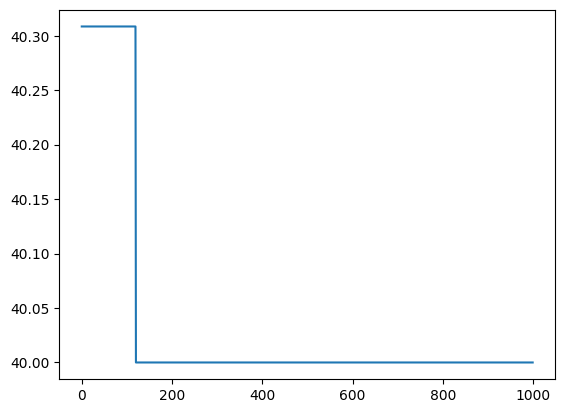

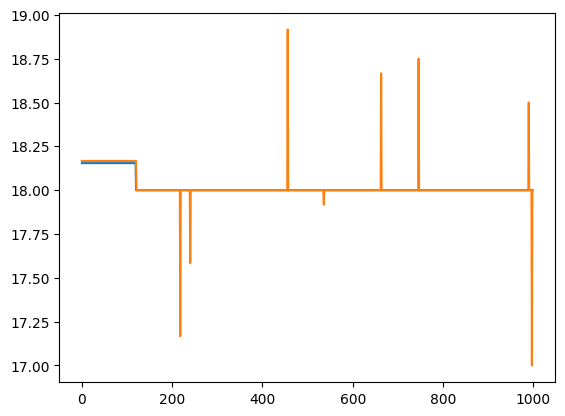

In [179]:
import matplotlib.pyplot as plt
k = 1000
plt.plot(u_history[-k:])
plt.show()

plt.plot(qm_history[-k:])
plt.plot(q1_history[-k:])
plt.show()

### Correlations with shocks

In [180]:
k = 1000
np.corrcoef(u_history[-k:], q1_history[-k:])

array([[1.  , 0.65],
       [0.65, 1.  ]])

### Impulse Response

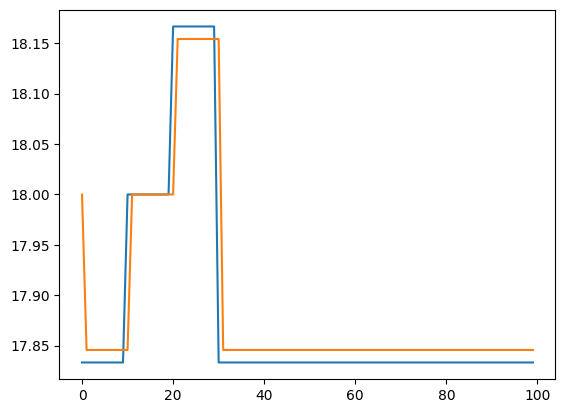

In [187]:
# initialize the state
u = 40
uidx = 1
q1_impulse=[]
qm_history = []
temperature=0.0001
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 100
for episode in range(num_episodes):

    if episode in [10]:
        uidx = 2 
    elif episode in [20]:
        uidx = 3
    elif episode in [30]:
        uidx = 1
        
    action1 = boltzmann_action_selection(Q1,uidx,temperature)

    quantity1 = action2quantity[action1]

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1)

   # generate shock
    #uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)

    q1_impulse.append(quantity1)
    qm_history.append(cournot(u,v,w,n).Qm)
    
    u = 40 + Z[uidx]


import matplotlib.pyplot as plt
plt.plot(q1_impulse)
plt.plot(qm_history)
plt.show()